# README Image Generator

Generates visualizations for the [baseball_game_simulator](https://github.com/dgrifka/baseball_game_simulator) README.

## Outputs

1. **Spray Angle Validation** — Shows handedness adjustment works correctly
2. **Feature Importance** — Model feature importance by category
3. **EV vs LA with Spray Angle** — Classic sweet spot view with spray angle as color
4. **Example Spray Chart** — Game visualization from the simulator

Run all cells, then download images from `readme_images/` folder.

In [31]:
# =============================================================================
# SETUP
# =============================================================================
import os

# Clone the public repo
if not os.path.exists('/content/baseball_game_simulator'):
    !git clone https://github.com/dgrifka/baseball_game_simulator.git /content/baseball_game_simulator

os.chdir('/content/baseball_game_simulator')

# Create output directory
OUTPUT_DIR = '/content/readme_images'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Working directory: {os.getcwd()}")
print(f"Output directory: {OUTPUT_DIR}")

Working directory: /content/baseball_game_simulator
Output directory: /content/readme_images


In [32]:
# =============================================================================
# IMPORTS
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for clean README images
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 11

In [33]:
# =============================================================================
# LOAD DATA
# =============================================================================
DATA_PATH = 'Data'
SEASONS = [2024, 2025]

# Load batted ball data
batted_balls_list = []
for season in SEASONS:
    file_path = f'{DATA_PATH}/batted_balls/batted_balls_{season}.parquet'
    if os.path.exists(file_path):
        df_season = pd.read_parquet(file_path)
        batted_balls_list.append(df_season)
        print(f"✓ Loaded {season}: {len(df_season):,} rows")

batted_balls = pd.concat(batted_balls_list, ignore_index=True)

# Load games data
games = pd.read_parquet(f'{DATA_PATH}/games/games.parquet')

print(f"\nTotal batted balls: {len(batted_balls):,}")

✓ Loaded 2024: 125,908 rows
✓ Loaded 2025: 126,515 rows

Total batted balls: 252,423


In [34]:
# =============================================================================
# PREPARE DATA
# =============================================================================
# Merge with games for venue info
df = batted_balls.merge(
    games[['gamePk', 'venue_id', 'venue_name']],
    on='gamePk',
    how='left'
)

# Filter to valid data
required_cols = ['hitData_launchSpeed', 'hitData_launchAngle',
                 'hitData_coordinates_coordX', 'hitData_coordinates_coordY']
df = df.dropna(subset=required_cols)

# Standardize outcomes
hit_types = ['single', 'double', 'triple', 'home_run']
df['eventType'] = df['eventType'].apply(lambda x: x if x in hit_types else 'out')

print(f"✓ Rows after filtering: {len(df):,}")

✓ Rows after filtering: 253,802


In [35]:
# =============================================================================
# CALCULATE SPRAY ANGLE
# =============================================================================
HOME_PLATE_X = 125.42
HOME_PLATE_Y = 199.02

def calculate_spray_angle(coord_x, coord_y):
    """Calculate spray angle (0° = center, negative = left field, positive = right field)"""
    delta_x = coord_x - HOME_PLATE_X
    delta_y = HOME_PLATE_Y - coord_y
    return np.degrees(np.arctan2(delta_x, delta_y))

def adjust_spray_for_handedness(spray_angle, bat_side):
    """Adjust so negative = pull side for both L and R batters"""
    return -spray_angle if bat_side == 'L' else spray_angle

df['spray_angle'] = calculate_spray_angle(
    df['hitData_coordinates_coordX'],
    df['hitData_coordinates_coordY']
)

df['spray_angle_adj'] = df.apply(
    lambda row: adjust_spray_for_handedness(row['spray_angle'], row['batSide_code']),
    axis=1
)

print("✓ Spray angle calculated")
print(f"  Range: {df['spray_angle_adj'].min():.1f}° to {df['spray_angle_adj'].max():.1f}°")

✓ Spray angle calculated
  Range: -180.0° to 179.9°


---
## 1. Spray Angle Validation

Shows that the handedness adjustment works correctly — pull side (blue) is normalized to the LEFT for both RHB and LHB.

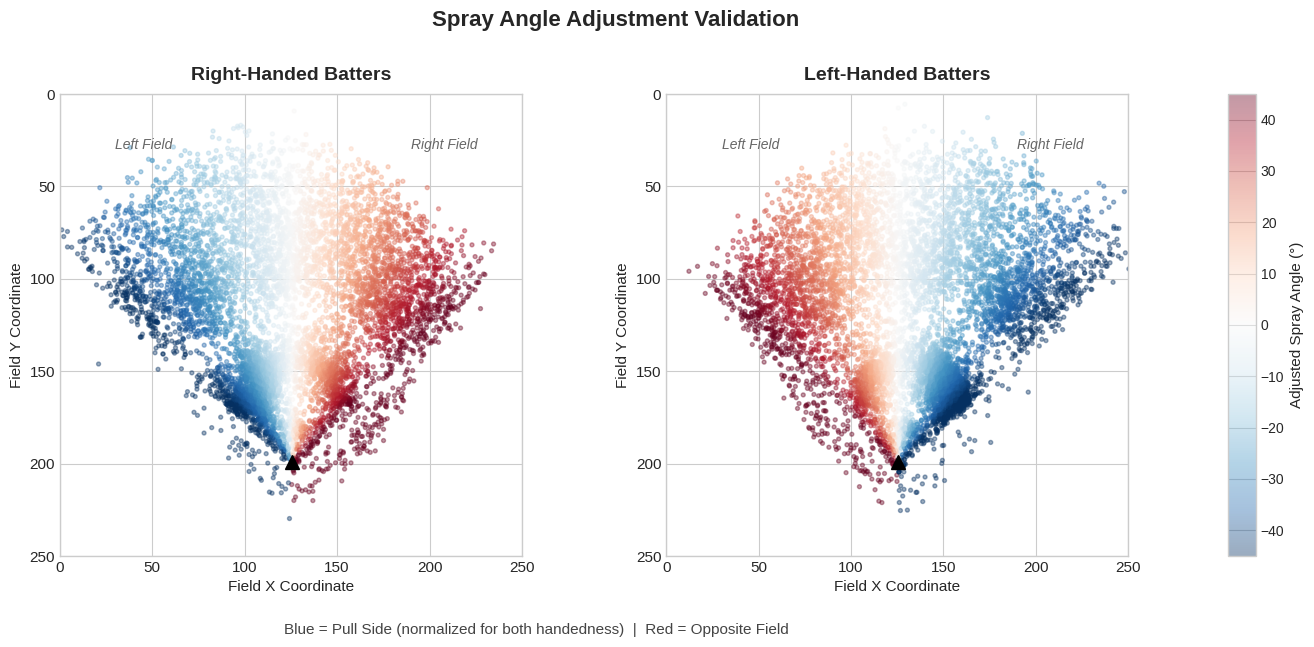

In [36]:
# Create figure with extra space on the right for colorbar
fig = plt.figure(figsize=(16, 6))

# Create gridspec for precise layout control
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.15)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
cax = fig.add_subplot(gs[2])  # Dedicated colorbar axes

axes = [ax1, ax2]

for idx, bat_side in enumerate(['R', 'L']):
    ax = axes[idx]
    subset = df[df['batSide_code'] == bat_side].sample(min(8000, len(df)), random_state=42)

    scatter = ax.scatter(
        subset['hitData_coordinates_coordX'],
        subset['hitData_coordinates_coordY'],
        c=subset['spray_angle_adj'],
        cmap='RdBu_r',
        alpha=0.4,
        s=8,
        vmin=-45,
        vmax=45
    )

    # Add home plate marker
    ax.plot(HOME_PLATE_X, HOME_PLATE_Y, 'k^', markersize=10, zorder=5)

    title = 'Right-Handed Batters' if bat_side == 'R' else 'Left-Handed Batters'
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Field X Coordinate', fontsize=11)
    ax.set_ylabel('Field Y Coordinate', fontsize=11)
    ax.set_xlim(0, 250)
    ax.set_ylim(0, 250)
    ax.invert_yaxis()
    ax.set_aspect('equal')

    # Add annotations
    ax.text(30, 30, 'Left Field', fontsize=10, color='#666', style='italic')
    ax.text(190, 30, 'Right Field', fontsize=10, color='#666', style='italic')

# Colorbar in dedicated axes on the right
cbar = fig.colorbar(scatter, cax=cax, label='Adjusted Spray Angle (°)')
cbar.ax.tick_params(labelsize=10)

# Main title
fig.suptitle('Spray Angle Adjustment Validation', fontsize=16, fontweight='bold', y=1.02)

# Add explanation at bottom
fig.text(0.45, -0.02, 'Blue = Pull Side (normalized for both handedness)  |  Red = Opposite Field',
         ha='center', fontsize=11, color='#444')

plt.savefig(f'{OUTPUT_DIR}/spray_angle_validation.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

---
## 2. Feature Importance by Category

Shows relative importance of different feature groups in the trained model.

In [37]:
# Load model and extract feature importance
MODEL_PATH = 'Model/batted_ball_model.pkl'
pipeline = joblib.load(MODEL_PATH)

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_importance = pipeline.named_steps['classifier'].feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("✓ Model loaded")
print(f"  Total features: {len(feature_names)}")

✓ Model loaded
  Total features: 58


In [38]:
# Calculate importance by category
core_features = ['hitData_launchSpeed', 'hitData_launchAngle', 'distance_proxy']
spray_features = ['spray_angle', 'is_pulled', 'is_opposite', 'pulled_hard', 'oppo_hard',
                  'spray_ev_interaction', 'pulled_ground_ball', 'oppo_line_drive', 'spray_direction']

core_imp = importance_df[importance_df['feature'].str.contains('|'.join(core_features))]['importance'].sum()
spray_imp = importance_df[importance_df['feature'].str.contains('|'.join(spray_features))]['importance'].sum()
barrel_imp = importance_df[importance_df['feature'].str.contains('is_barrel')]['importance'].sum()
la_cat_imp = importance_df[importance_df['feature'].str.contains('launch_angle_category')]['importance'].sum()
venue_imp = importance_df[importance_df['feature'].str.contains('venue_id')]['importance'].sum()

# Create grouped data
categories = ['Exit Velocity &\nLaunch Angle', 'Spray Angle\nFeatures',
              'Launch Angle\nCategory', 'Barrel\nIndicator', 'Venue\nEffects']
values = [core_imp, spray_imp, la_cat_imp, barrel_imp, venue_imp]
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B']

print("Feature importance by category:")
for cat, val in zip(categories, values):
    print(f"  {cat.replace(chr(10), ' ')}: {val:.1%}")

Feature importance by category:
  Exit Velocity & Launch Angle: 57.7%
  Spray Angle Features: 22.8%
  Launch Angle Category: 14.1%
  Barrel Indicator: 4.6%
  Venue Effects: 0.8%


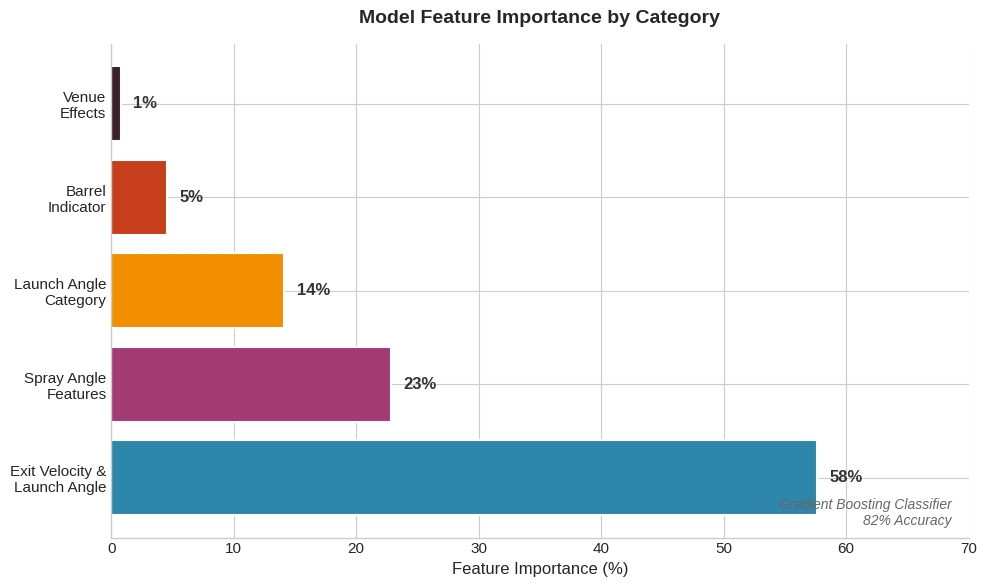

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(categories, [v * 100 for v in values], color=colors, edgecolor='white', linewidth=1.5)

# Add value labels
for bar, val in zip(bars, values):
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            f'{val:.0%}', va='center', fontsize=12, fontweight='bold', color='#333')

ax.set_xlabel('Feature Importance (%)', fontsize=12)
ax.set_title('Model Feature Importance by Category', fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(0, 70)

# Clean up
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', labelsize=11)

# Add model info
ax.text(0.98, 0.02, 'Gradient Boosting Classifier\n82% Accuracy',
        transform=ax.transAxes, ha='right', va='bottom',
        fontsize=10, color='#666', style='italic')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/feature_importance.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

---
## 3. EV vs LA with Spray Angle

Shows Exit Velocity vs Launch Angle (the classic "sweet spot" view) with spray angle shown as color.
Marker size indicates outcome quality (larger = more bases).

In [40]:
# Sample data for visualization
sample_size = 12000
df_sample = df.sample(n=min(sample_size, len(df)), random_state=42).copy()

# Map outcomes to numeric "bases" for sizing
outcome_to_bases = {
    'out': 0,
    'single': 1,
    'double': 2,
    'triple': 3,
    'home_run': 4
}
df_sample['bases'] = df_sample['eventType'].map(outcome_to_bases)

print(f"✓ Sampled {len(df_sample):,} batted balls")
print(f"\nOutcome distribution:")
print(df_sample['eventType'].value_counts())

✓ Sampled 12,000 batted balls

Outcome distribution:
eventType
out         8128
single      2505
double       752
home_run     556
triple        59
Name: count, dtype: int64


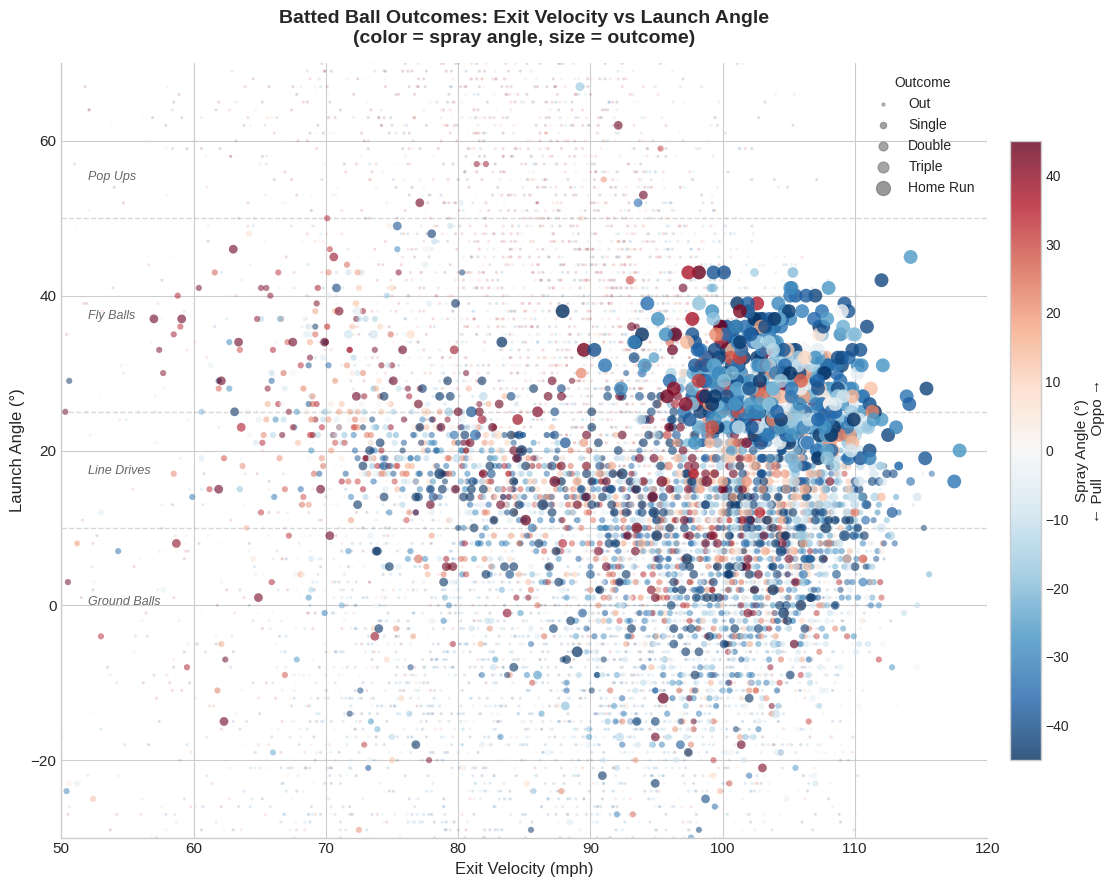

In [41]:
# =============================================================================
# EV vs LA with Spray Angle as Color
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 9))

# Size based on outcome (outs small, HRs large)
size_map = {0: 5, 1: 20, 2: 40, 3: 60, 4: 100}
sizes = df_sample['bases'].map(size_map)

# Alpha based on outcome (outs more transparent)
alpha_map = {0: 0.15, 1: 0.5, 2: 0.6, 3: 0.7, 4: 0.8}
alphas = df_sample['bases'].map(alpha_map)

# Plot outs first (background), then hits on top
for outcome_val in [0, 1, 2, 3, 4]:
    mask = df_sample['bases'] == outcome_val
    subset = df_sample[mask]

    scatter = ax.scatter(
        subset['hitData_launchSpeed'],
        subset['hitData_launchAngle'],
        c=subset['spray_angle_adj'],
        cmap='RdBu_r',
        s=sizes[mask],
        alpha=alphas[mask].iloc[0] if len(alphas[mask]) > 0 else 0.3,
        vmin=-45,
        vmax=45,
        edgecolors='none'
    )

# Colorbar for spray angle
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label('Spray Angle (°)\n← Pull          Oppo →', fontsize=11)
cbar.ax.tick_params(labelsize=10)

# Labels and title
ax.set_xlabel('Exit Velocity (mph)', fontsize=12)
ax.set_ylabel('Launch Angle (°)', fontsize=12)
ax.set_title('Batted Ball Outcomes: Exit Velocity vs Launch Angle\n(color = spray angle, size = outcome)',
             fontsize=14, fontweight='bold', pad=15)

ax.set_xlim(50, 120)
ax.set_ylim(-30, 70)

# Add reference zones
ax.axhline(y=10, color='gray', linestyle='--', alpha=0.3, linewidth=1)
ax.axhline(y=25, color='gray', linestyle='--', alpha=0.3, linewidth=1)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.3, linewidth=1)

# Zone labels
ax.text(52, 0, 'Ground Balls', fontsize=9, color='#666', style='italic')
ax.text(52, 17, 'Line Drives', fontsize=9, color='#666', style='italic')
ax.text(52, 37, 'Fly Balls', fontsize=9, color='#666', style='italic')
ax.text(52, 55, 'Pop Ups', fontsize=9, color='#666', style='italic')

# Add legend for sizes
legend_elements = [
    plt.scatter([], [], s=5, c='gray', alpha=0.5, label='Out'),
    plt.scatter([], [], s=20, c='gray', alpha=0.7, label='Single'),
    plt.scatter([], [], s=40, c='gray', alpha=0.7, label='Double'),
    plt.scatter([], [], s=60, c='gray', alpha=0.7, label='Triple'),
    plt.scatter([], [], s=100, c='gray', alpha=0.8, label='Home Run'),
]
ax.legend(handles=legend_elements, loc='upper right', title='Outcome',
          fontsize=10, title_fontsize=10, framealpha=0.9)

# Clean up
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/ev_la_spray_angle.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

---
## 4. Example Spray Chart (Game Visualization)

Generates a spray chart using the actual `spray_chart()` function from the simulator.

In [42]:
# Import simulator functions
import requests
from PIL import Image
from io import BytesIO

from Simulator.get_game_information import get_game_info, response_code
from Simulator.game_simulator import outcomes, simulator
from Simulator.visualizations import spray_chart
from Simulator.constants import TEAM_LOGO_MAP, base_url, game_ver, VENUE_NAME_TO_ID

In [43]:
# =============================================================================
# EXAMPLE GAME CONFIGURATION
# =============================================================================
# Use a specific game from the 2024 season

EXAMPLE_GAME_ID = 813024

print(f"Using game_id: {EXAMPLE_GAME_ID}")

Using game_id: 813024


In [44]:
# =============================================================================
# FETCH GAME METADATA FROM MLB API
# =============================================================================

def get_game_metadata(game_id):
    """
    Fetch game metadata (teams, scores, venue) directly from MLB API.
    """
    endpoint = f'game/{game_id}/feed/live'
    game_data = response_code(base_url, game_ver, endpoint)

    game_info = game_data['gameData']
    line_score = game_data['liveData']['linescore']

    return {
        'home_team': game_info['teams']['home']['teamName'],
        'away_team': game_info['teams']['away']['teamName'],
        'home_score': line_score['teams']['home']['runs'],
        'away_score': line_score['teams']['away']['runs'],
        'venue': game_info['venue']['name'],
        'date': game_info['datetime']['officialDate']
    }

# Get game metadata
game_meta = get_game_metadata(EXAMPLE_GAME_ID)

home_team = game_meta['home_team']
away_team = game_meta['away_team']
home_score = game_meta['home_score']
away_score = game_meta['away_score']
venue = game_meta['venue']
game_date = game_meta['date']

print(f"\n{'='*50}")
print(f"  {away_team} {away_score} @ {home_team} {home_score}")
print(f"  Venue: {venue}")
print(f"  Date: {game_date}")
print(f"{'='*50}")

https://statsapi.mlb.com/api/v1.1/game/813024/feed/live

  Dodgers 5 @ Blue Jays 4
  Venue: Rogers Centre
  Date: 2025-11-01


In [45]:
# =============================================================================
# GET PLAY-BY-PLAY DATA
# =============================================================================

result = get_game_info(EXAMPLE_GAME_ID, all_columns=False)

if result is None:
    print("Error: Could not retrieve game data")
else:
    game_data_df, all_pbp, steals_and_pickoffs = result

    # Add venue name to game_data (required for outcomes function)
    game_data_df['venue.name'] = venue

    # Clean steals data
    if len(steals_and_pickoffs) > 0:
        steals_and_pickoffs = steals_and_pickoffs.drop_duplicates(subset=['startTime'], keep='first')

    print(f"✓ Retrieved {len(game_data_df)} plate appearances")
    print(f"✓ Retrieved {len(steals_and_pickoffs)} steals/pickoffs")

    # Debug: Check what columns we have
    print(f"\nKey columns check:")
    coord_cols = [c for c in game_data_df.columns if 'coord' in c.lower()]
    print(f"  Coordinate columns: {coord_cols}")

    # Check for batted ball data
    has_launch = 'hitData.launchSpeed' in game_data_df.columns
    has_coords = 'hitData.coordinates.coordX' in game_data_df.columns
    print(f"  Has launch data: {has_launch}")
    print(f"  Has coordinate data: {has_coords}")

https://statsapi.mlb.com/api/v1.1/game/813024/feed/live
✓ Retrieved 97 plate appearances
✓ Retrieved 1 steals/pickoffs

Key columns check:
  Coordinate columns: ['hitData.coordinates.coordX', 'hitData.coordinates.coordY']
  Has launch data: True
  Has coordinate data: True


In [46]:
# =============================================================================
# CALCULATE OUTCOMES FOR EACH TEAM
# =============================================================================

home_outcomes = outcomes(game_data_df, steals_and_pickoffs, 'home')
away_outcomes = outcomes(game_data_df, steals_and_pickoffs, 'away')

print(f"\nOutcomes retrieved:")
print(f"  {home_team}: {len(home_outcomes)} events")
print(f"  {away_team}: {len(away_outcomes)} events")

# Debug: Check structure of first few outcomes
print(f"\n--- Debug: Sample outcome structure ---")
batted_ball_count = 0
for i, outcome in enumerate(home_outcomes[:5]):
    if isinstance(outcome, tuple) and len(outcome) >= 1:
        outcome_data = outcome[0]
        if isinstance(outcome_data, dict):
            has_coords = 'coord_x' in outcome_data and outcome_data.get('coord_x') is not None
            print(f"  [{i}] dict with coord_x={outcome_data.get('coord_x')}, coord_y={outcome_data.get('coord_y')}")
            if has_coords:
                batted_ball_count += 1
        elif outcome_data == 'walk':
            print(f"  [{i}] walk")
        elif outcome_data == 'strikeout':
            print(f"  [{i}] strikeout")
        else:
            print(f"  [{i}] other: {type(outcome_data)}")
    else:
        print(f"  [{i}] not tuple: {type(outcome)}")

# Count total batted balls with coordinates
total_with_coords = 0
for outcome in home_outcomes + away_outcomes:
    if isinstance(outcome, tuple) and isinstance(outcome[0], dict):
        if outcome[0].get('coord_x') is not None:
            total_with_coords += 1

print(f"\nTotal batted balls with coordinates: {total_with_coords}")


Outcomes retrieved:
  Blue Jays: 50 events
  Dodgers: 48 events

--- Debug: Sample outcome structure ---
  [0] strikeout
  [1] strikeout
  [2] strikeout
  [3] strikeout
  [4] strikeout

Total batted balls with coordinates: 70


In [47]:
# =============================================================================
# RUN SIMULATION
# =============================================================================

home_clean = [o[0] if isinstance(o, tuple) else o for o in home_outcomes]
away_clean = [o[0] if isinstance(o, tuple) else o for o in away_outcomes]

num_simulations = 10000
home_runs, away_runs, home_win_pct, away_win_pct, tie_pct = simulator(
    num_simulations, home_clean, away_clean
)

print(f"\nSimulation Results ({num_simulations:,} simulations):")
print(f"  {away_team}: {away_win_pct}% win probability")
print(f"  {home_team}: {home_win_pct}% win probability")
print(f"  Tie: {tie_pct}%")

Simulating games: 100%|################| 10000/10000 [00:01<00:00, 9582.76sim/s]


Simulation Results (10,000 simulations):
  Dodgers: 60.36% win probability
  Blue Jays: 29.74% win probability
  Tie: 9.9%


In [48]:
# =============================================================================
# LOAD TEAM LOGOS
# =============================================================================
# Import the logo list from constants (NOT TEAM_LOGO_MAP)
from Simulator.constants import mlb_team_logos

# spray_chart() expects the raw list - it loads images internally
print(f"✓ Loaded {len(mlb_team_logos)} team logo URLs")

# Verify our teams are in the list
teams_in_list = [t['team'] for t in mlb_team_logos]
print(f"  Home team '{home_team}' in list: {home_team in teams_in_list}")
print(f"  Away team '{away_team}' in list: {away_team in teams_in_list}")

✓ Loaded 32 team logo URLs
  Home team 'Blue Jays' in list: True
  Away team 'Dodgers' in list: True


In [49]:
# =============================================================================
# GENERATE SPRAY CHART
# =============================================================================

formatted_date = pd.to_datetime(game_date).strftime("%m/%d/%Y")

print(f"Generating spray chart...")
print(f"  Home: {home_team} ({len(home_outcomes)} events)")
print(f"  Away: {away_team} ({len(away_outcomes)} events)")
print(f"  Venue: {venue}")
print(f"  Date: {formatted_date}")

spray_chart(
    home_outcomes, away_outcomes,
    home_team, away_team,
    home_score, away_score,
    home_win_pct, away_win_pct, tie_pct,
    mlb_team_logos,
    formatted_date,
    venue_name=venue,
    images_dir=OUTPUT_DIR
)

Generating spray chart...
  Home: Blue Jays (50 events)
  Away: Dodgers (48 events)
  Venue: Rogers Centre
  Date: 11/01/2025
Saved spray chart: /content/readme_images/Dodgers_Blue Jays_5-4--60-30_spray.png


'/content/readme_images/Dodgers_Blue Jays_5-4--60-30_spray.png'

---
## Summary

All images have been generated and saved to `/content/readme_images/`.

In [50]:
# List all generated images
print("="*50)
print("GENERATED IMAGES")
print("="*50)

for f in sorted(os.listdir(OUTPUT_DIR)):
    if f.endswith('.png'):
        size = os.path.getsize(f'{OUTPUT_DIR}/{f}') / 1024
        print(f"  ✓ {f} ({size:.1f} KB)")

GENERATED IMAGES
  ✓ Dodgers_Blue Jays_5-4--60-30_spray.png (658.5 KB)
  ✓ ev_la_spray_angle.png (845.6 KB)
  ✓ feature_importance.png (71.6 KB)
  ✓ spray_angle_validation.png (866.7 KB)
